# VAE training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyeit import mesh
from sciopy import plot_mesh
from util import plot_mesh_permarray

In [2]:
n_el = 32
n_samples = 10_000
noise = 0.5  # Standard deviation of the Gaussian distributed noise (spread or "width")
balloon_perm = 10

In [3]:
# create uniform distributed radii
rs = np.random.uniform(low=0, high=0.6, size=n_samples)

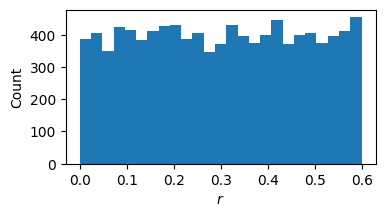

In [4]:
plt.figure(figsize=(4, 2))
plt.hist(rs, bins=25)
plt.xlabel("$r$")
plt.ylabel("Count")
plt.show()

In [5]:
# Create mesh
mesh_obj = mesh.create(n_el=32, h0=0.05)

In [6]:
γ = list()

for r in rs:
    balloon_anmly = mesh.wrapper.PyEITAnomaly_Circle(
        center=[0, 0], r=r, perm=balloon_perm
    )
    mesh_obj = mesh.set_perm(mesh_obj, anomaly=balloon_anmly, background=1.0)
    perm_noisy = mesh_obj.perm_array + np.random.normal(
        scale=0.5, size=mesh_obj.perm_array.shape[0]
    )
    γ.append(perm_noisy)
    if n_samples <= 5:
        plot_mesh_permarray(mesh_obj, perm_noisy)

γ = np.array(γ) / 15  # !!! Divided by 15
γ = np.expand_dims(γ, axis=2)
assert γ.shape[0] == n_samples, "Something went wrong."

In [7]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
from vae_model import vae_model
from sklearn.model_selection import train_test_split

2024-09-19 13:08:01.145965: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-19 13:08:01.761811: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-19 13:08:02.745801: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


In [16]:
vae = vae_model()
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [17]:
# vae.encoder.summary()

In [18]:
# vae.decoder.summary()

In [19]:
γ_train, γ_test = train_test_split(γ, test_size=0.2, random_state=42)

In [20]:
γ_train.shape, γ_test.shape

((8000, 2840, 1), (2000, 2840, 1))

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - kl_loss: 5.3099 - loss: 62.3510 - reconstruction_loss: 57.0410 - val_kl_loss: 6.6631 - val_loss: 23.7226 - val_reconstruction_loss: 17.0595
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - kl_loss: 6.2788 - loss: 21.9621 - reconstruction_loss: 15.6833 - val_kl_loss: 5.7463 - val_loss: 18.4414 - val_reconstruction_loss: 12.6950
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - kl_loss: 5.1760 - loss: 17.3601 - reconstruction_loss: 12.1841 - val_kl_loss: 4.7186 - val_loss: 16.4635 - val_reconstruction_loss: 11.7449
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - kl_loss: 4.8334 - loss: 15.6021 - reconstruction_loss: 10.7687 - val_kl_loss: 4.2686 - val_loss: 14.4989 - val_reconstruction_loss: 10.2302
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - kl_loss: 4.5981 - loss: 14.4405 - reconstruction_loss: 9.8424 - val_kl_loss: 4.8007 - val_loss: 13.9215 - val_reconstruction_loss: 9.1208
Epoch 6/30
225/225 ━━━━━━━

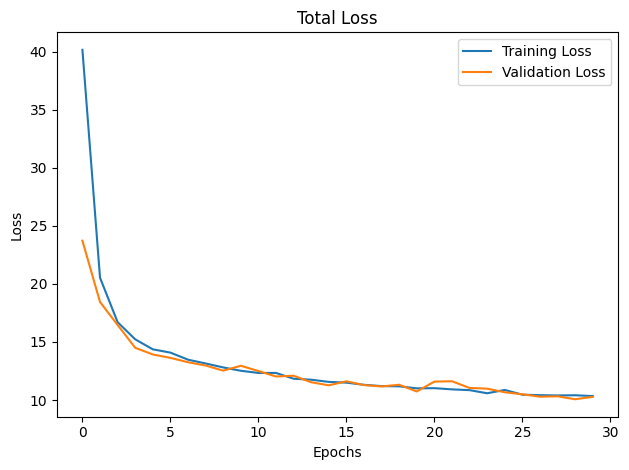

In [21]:
# Load the weights if they exist
weights_dir = "weights/"
vae_weights_file = os.path.join(weights_dir, "vae_2.weights.h5")

if os.path.exists(vae_weights_file):
    vae.load_weights(vae_weights_file)
    print("VAE weights loaded from file.")
else:
    history_vae = vae.fit(
        γ_train,
        epochs=30,
        batch_size=32,
        validation_split=0.1,
    )
    vae.save_weights(vae_weights_file)

    plt.plot(history_vae.history["loss"], label="Training Loss")
    plt.plot(history_vae.history["val_loss"], label="Validation Loss")
    plt.title("Total Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

**Test:** $\hat{\gamma}=\Psi(\text{random})$

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


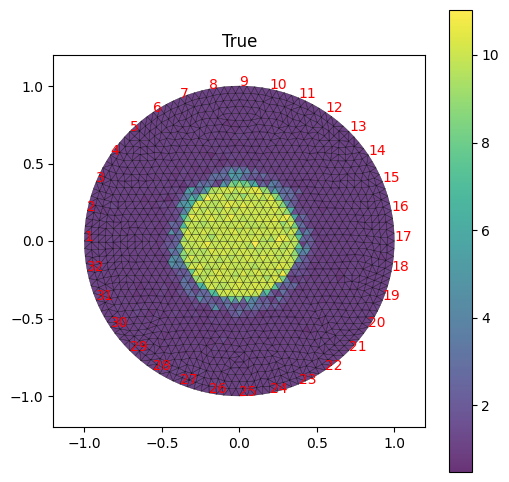

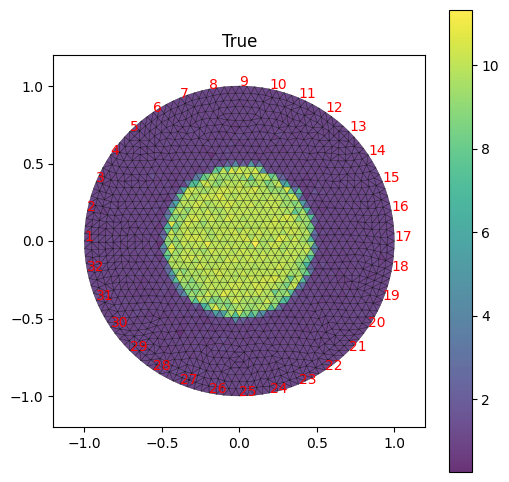

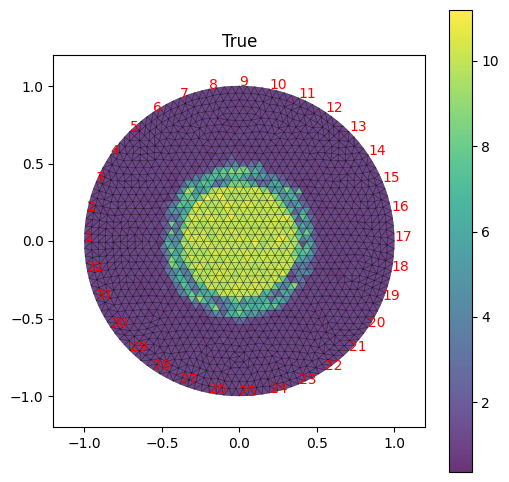

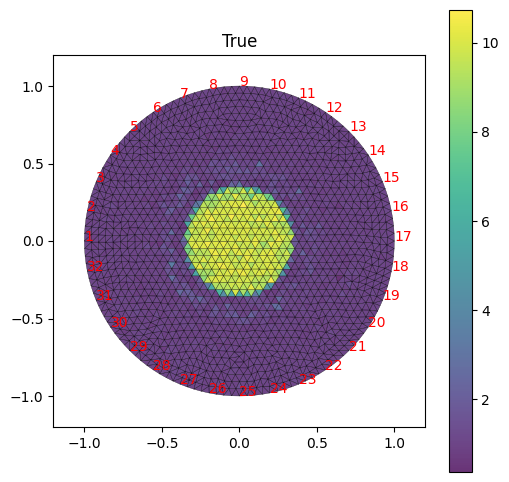

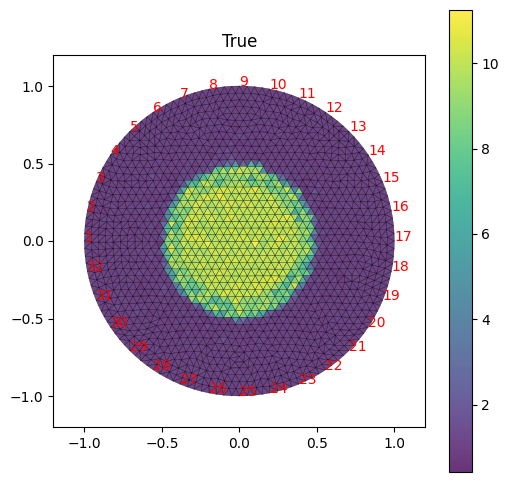

In [25]:
latent_space = 8

z_rdn = np.random.random(size=(5, 8))
γ_hat = vae.decoder.predict(z_rdn) * 15

for idx in range(γ_hat.shape[0]):
    plot_mesh_permarray(mesh_obj, γ_hat[idx, :, 0], title="True")

**Test:** $\hat{\gamma} \approx \Psi(\Phi(\gamma))$

In [26]:
z_mean, z_log_var, z = vae.encoder.predict(γ_test)
γ_hat = vae.decoder.predict(z) * 15

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


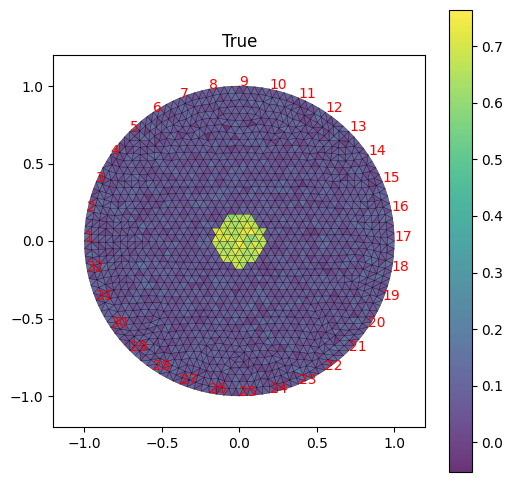

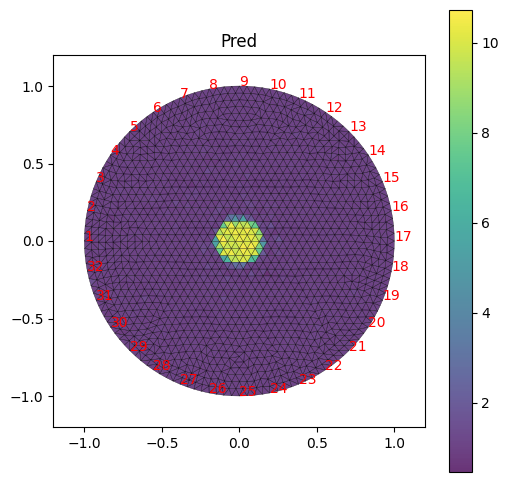

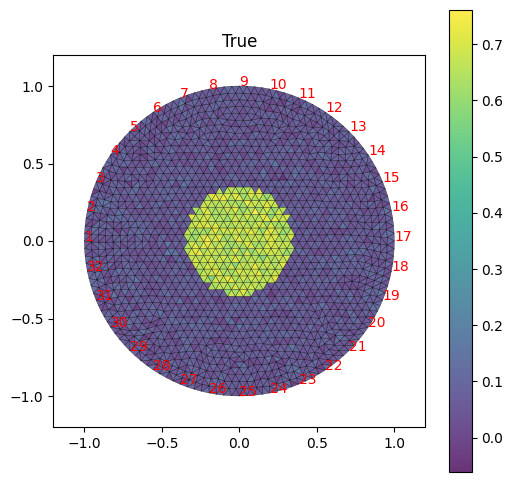

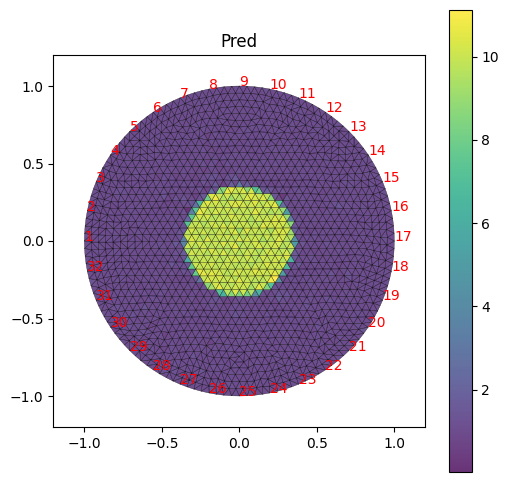

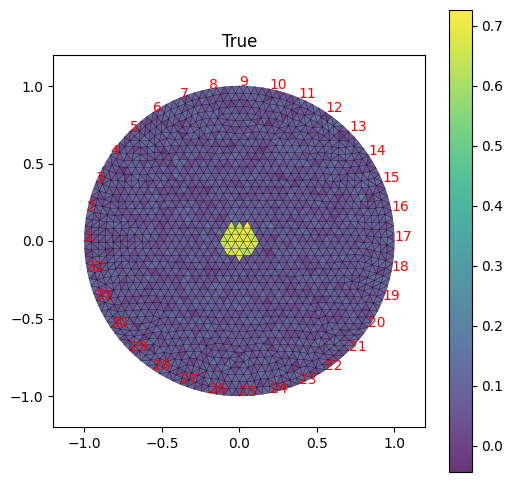

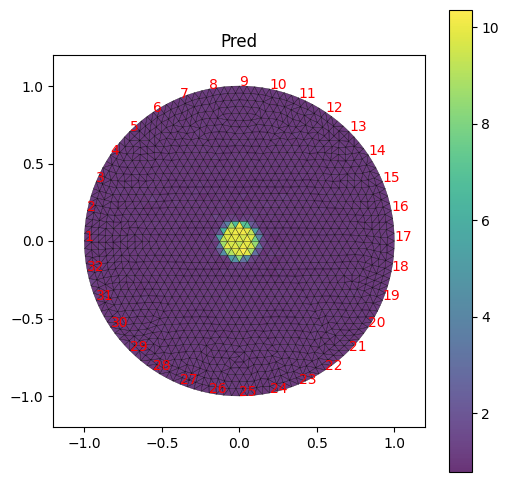

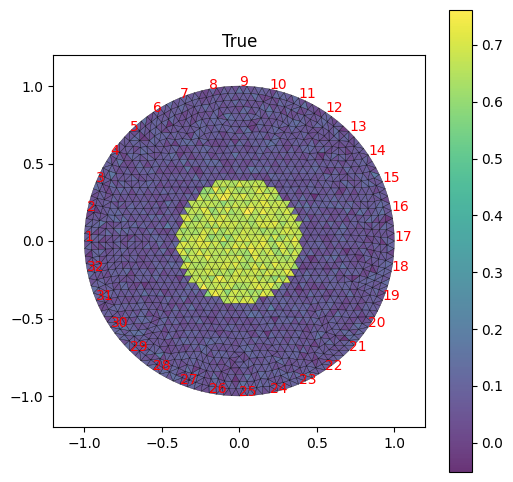

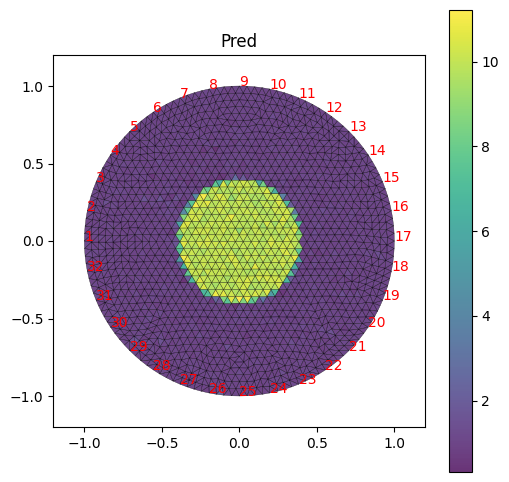

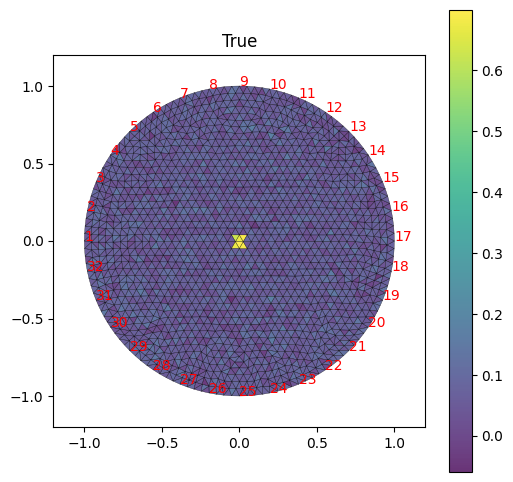

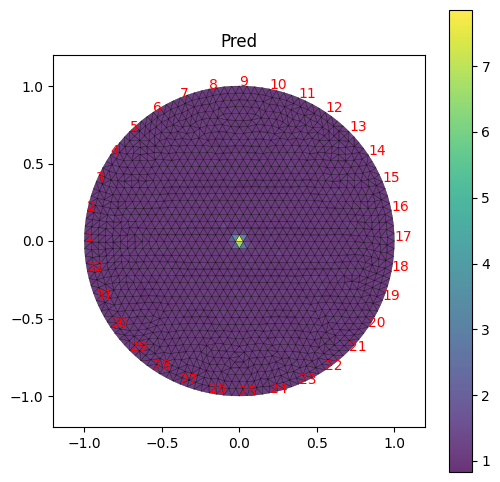

In [27]:
for idx in np.random.randint(0, high=γ_test.shape[0], size=5):
    plot_mesh_permarray(mesh_obj, γ_test[idx, :, 0], title="True")
    plot_mesh_permarray(mesh_obj, γ_hat[idx, :, 0], title="Pred")